In [1]:
import time
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from cellstitch.alignment import *
from cellpose.metrics import _label_overlap 

def display(fp):
    """
    Display frame0 and frame1 next to each other, with consistent colorings.
    """

    num_lbls = len(np.union1d(fp.frame0.get_lbls(), fp.frame1.get_lbls()))

    colors = np.random.random((num_lbls, 3))

    frames = np.array([fp.frame0.mask, fp.frame1.mask])
    rgb = color.label2rgb(frames, colors=colors, bg_label=0)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(rgb[0])
    axes[1].imshow(rgb[1])

    plt.tight_layout()
    plt.show()
    
def stitch3D(fp, z_stitched, epsilon=1e-10): 
    
    lbls0 = fp.frame0.get_lbls()
    lbls1 = fp.frame1.get_lbls()

    overlap = _label_overlap(fp.frame0.mask, fp.frame1.mask)

    # compute matching
    C = fp.get_cost_matrix(overlap)
    
    label_indexes0, label_indexes1 = np.where(overlap != 0) # only need to look at cells with overlap 

    for label_index0, label_index1 in zip(label_indexes0, label_indexes1):
        if label_index0 != 0 and label_index1 != 0: # only care about intersecting cells
            lbl0 = lbls0[label_index0]
            lbl1 = lbls1[label_index1]

            intersect_mask = (xy_masks[0] == lbl0) * (xy_masks[1] == lbl1)
            prop_stitched = z_stitched[np.where(intersect_mask)].sum() / intersect_mask.sum()

            C[label_index0][label_index1] /= (prop_stitched + epsilon)

    plan = fp.get_plan(C)

    # get a soft matching from plan
    n, m = plan.shape
    soft_matching = np.zeros((n, m))

    for i in range(n):
        matched_index = plan[i].argmax()
        soft_matching[i, matched_index] = 1

    mask0, mask1 = fp.frame0.mask, fp.frame1.mask

    stitched_mask1 = np.zeros(mask1.shape)
    for lbl1_index in range(1, m):
        # find the cell with the lowest cost (i.e. lowest scaled distance)
        matching_filter = soft_matching[:, lbl1_index]
        filtered_C = C[:, lbl1_index].copy()
        filtered_C[matching_filter == 0] = np.Inf  # ignore the non-matched cells

        lbl0_index = np.argmin(filtered_C)  # this is the cell0 we will attempt to relabel cell1 with

        lbl0, lbl1 = lbls0[lbl0_index], lbls1[lbl1_index]

        if lbl0 != 0:
            stitched_mask1[mask1 == lbl1] = lbl0
        else:
            fp.max_lbl += 1
            stitched_mask1[mask1 == lbl1] = fp.max_lbl
    fp.frame1 = Frame(stitched_mask1)

In [2]:
xy_masks = np.load('xy_masks.npy') # [z, x, y]]
xy_masks.shape

(129, 512, 512)

In [3]:
yz_masks = np.load('yz_masks.npy') # [x, z, y]
yz_masks.shape

(512, 129, 512)

In [4]:
yz_masks = yz_masks.transpose(1,0,2) # swap back to [z, x, y] for easy comparison"
yz_masks.shape

(129, 512, 512)

In [5]:
fp = FramePair(xy_masks[0], xy_masks[1])

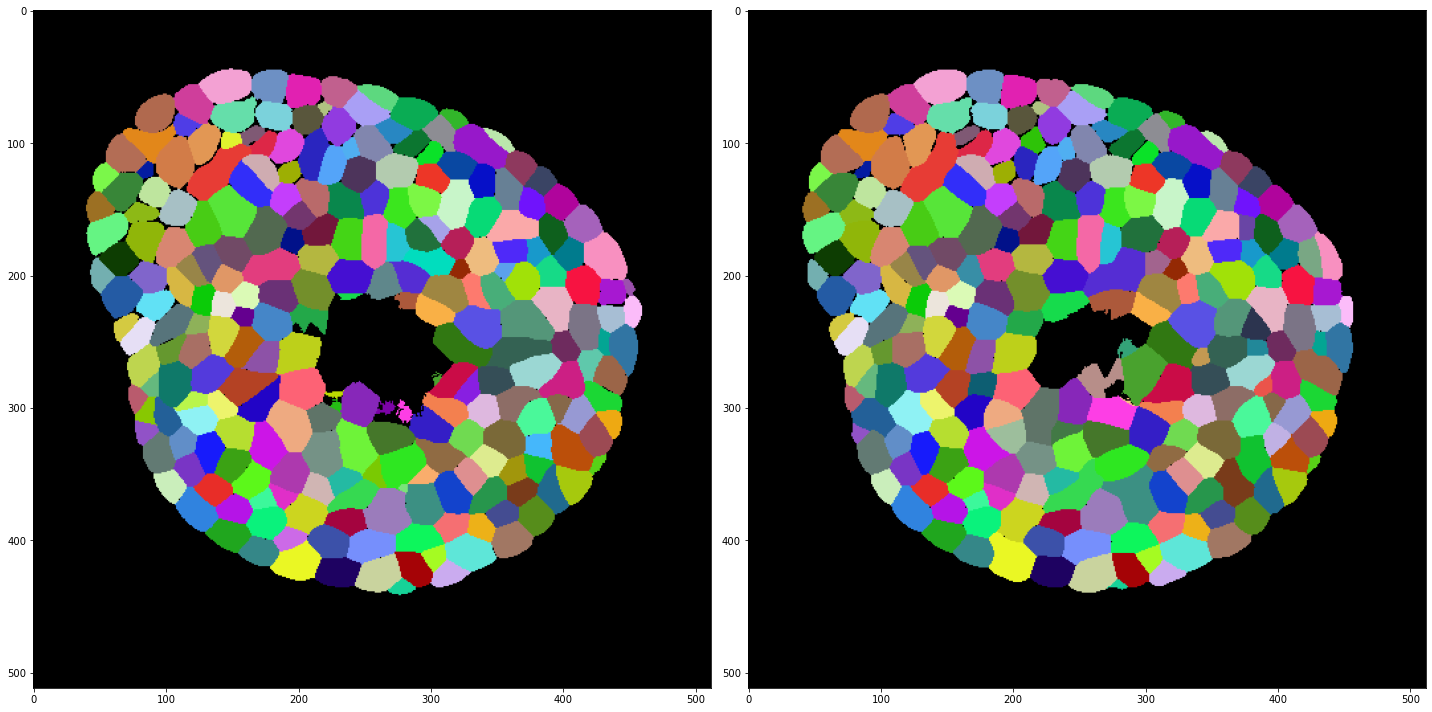

Stitching time: 0.9308638572692871 s.


In [6]:
start = time.time()
fp.stitch()
end = time.time()
display(fp)
print("Stitching time: %s s." % (end - start))

# Try new stitching idea!! 

In [7]:
xy_masks = np.load('xy_masks.npy')
yz_masks = np.load('yz_masks.npy').transpose(1,0,2)

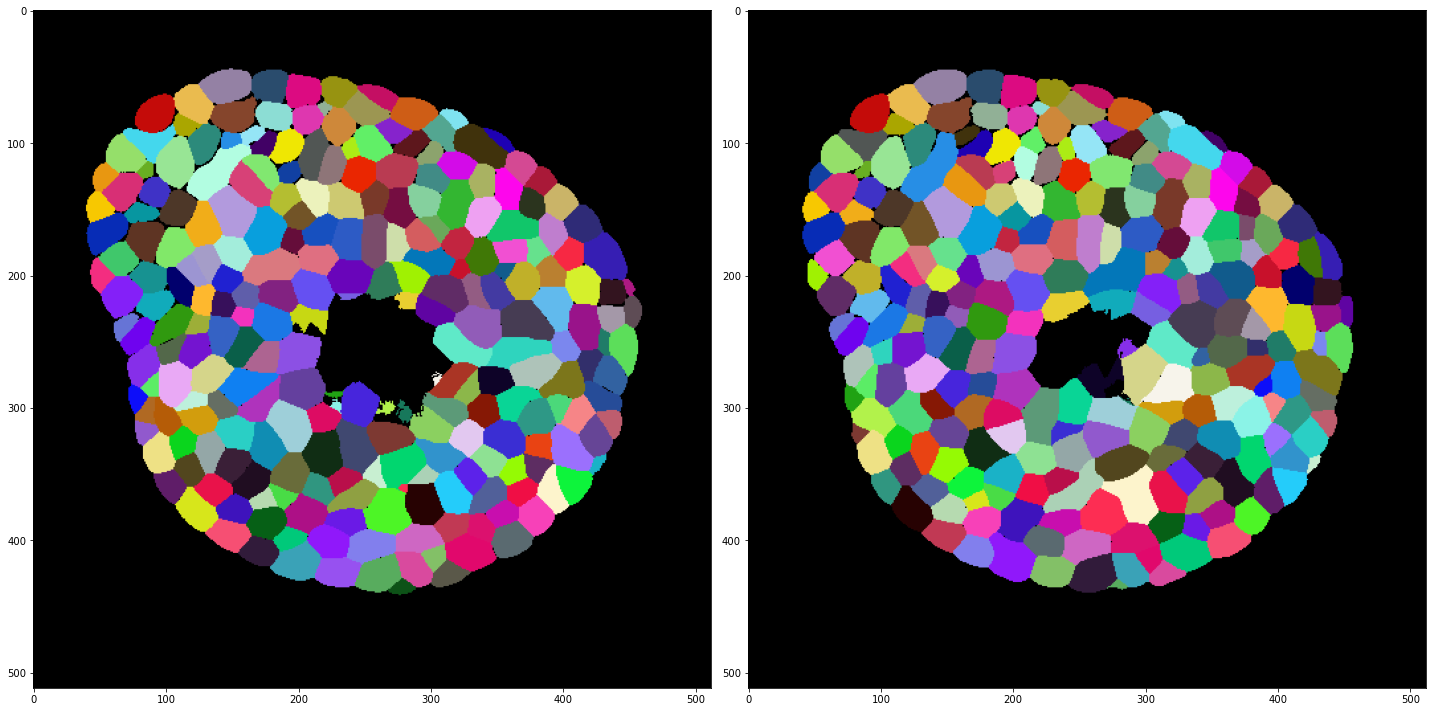

In [8]:
display(FramePair(xy_masks[0], xy_masks[1]))

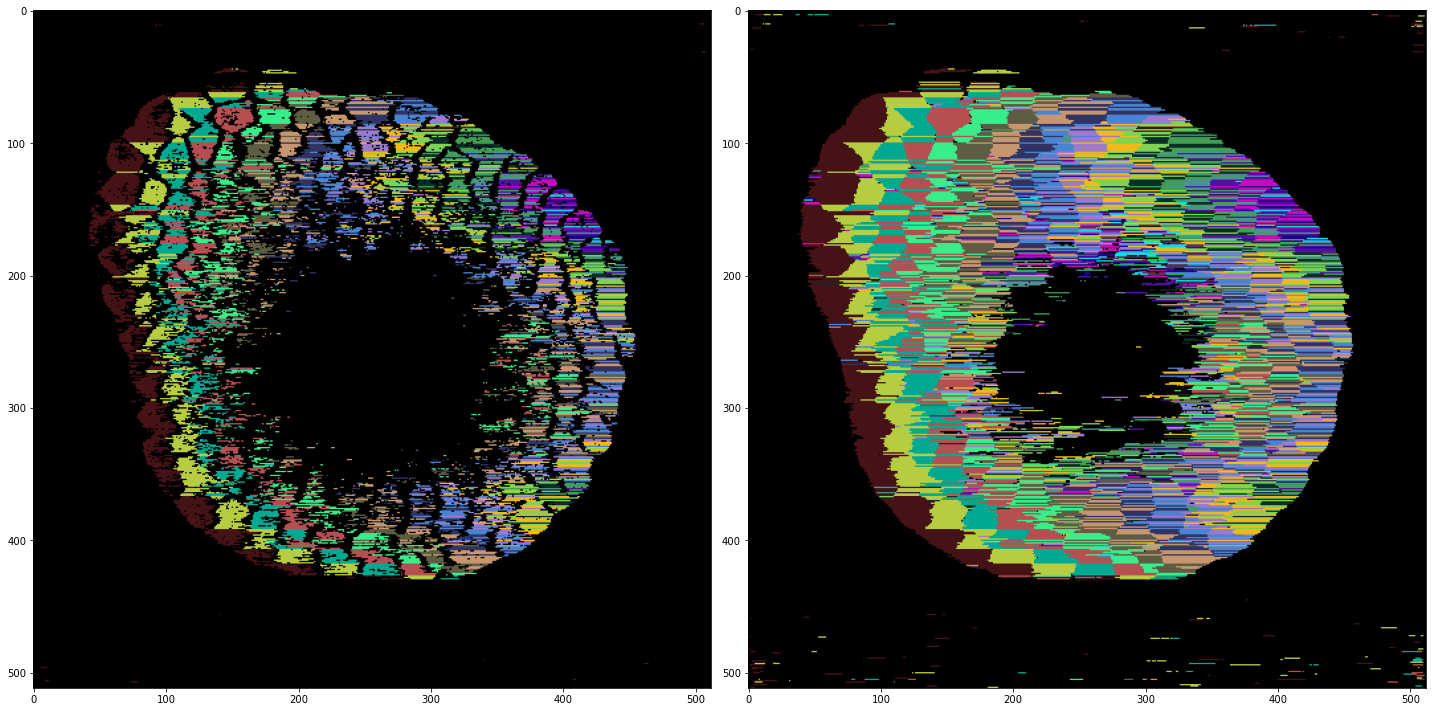

In [9]:
display(FramePair(yz_masks[0], yz_masks[1]))

In [10]:
z_stitched = yz_masks[0] == yz_masks[1] 

In [11]:
z_stitched.sum() / z_stitched.size

0.7899093627929688

we want to scale the original cost matrix; some cells are missed in yz slices, there is no stitching information is we only use yz slices to compute cost. We want to divide the cost matrix entry by the proportion of stitched pixels in the intersection. 

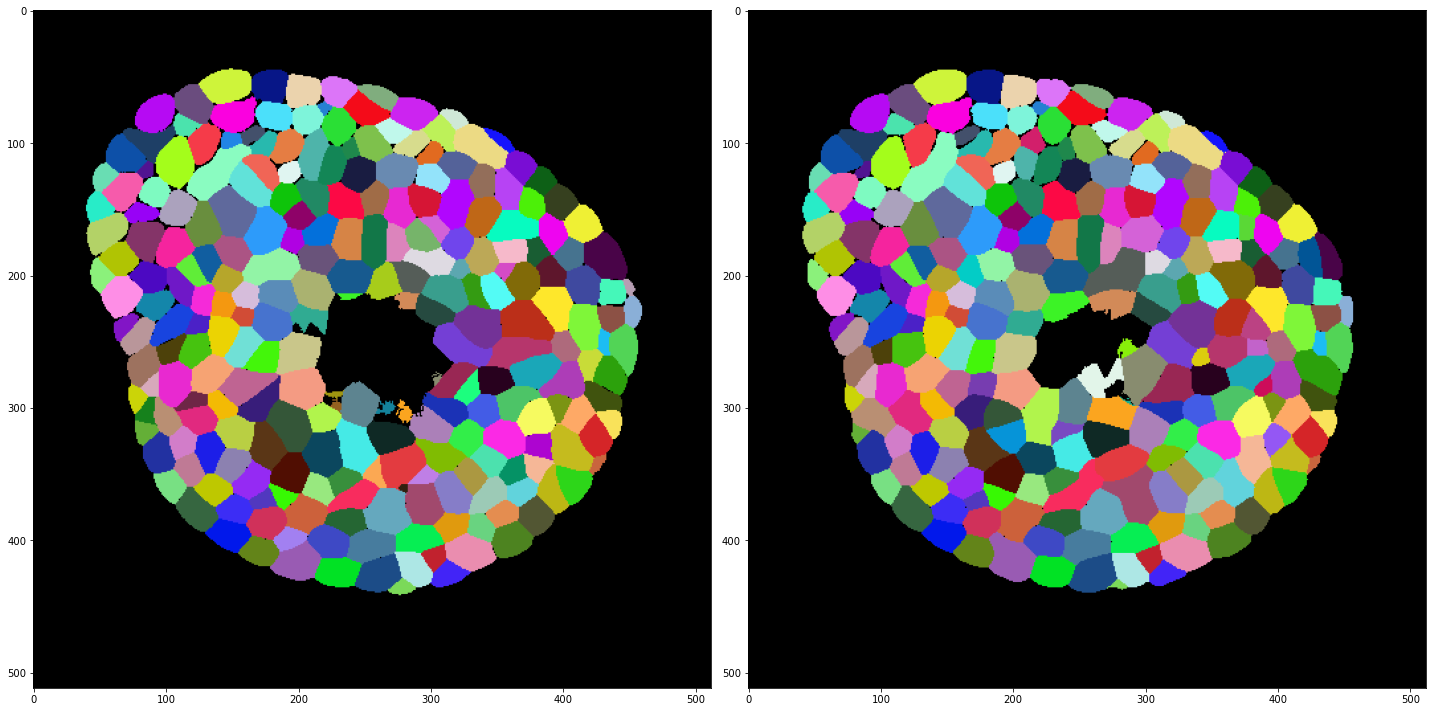

Stitching time: 1.2438695430755615 s.


In [14]:
fp = FramePair(xy_masks[0], xy_masks[1])
start = time.time()
stitch3D(fp, z_stitched)
end = time.time()
display(fp)
print("Stitching time: %s s." % (end - start))